# Explorative Analyse der Citibike Daten

Es werden verschiedene Visualisierungen der Citibike Daten betrachtet und diskutiert, welchen Mehrwert Citibike daraus ziehen könnte.

In [ ]:
from datasets.citibike_dataset import CitibikeDataset

citibike_dataset = CitibikeDataset("data/2023-citibike-tripdata/202312-citibike-tripdata/202312-citibike-tripdata_1.csv")

c:\Users\JanSchmitz\code\axa_challenge\datasets\citibike_dataset.py:37: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


Funktion, damit man sich in einem Plot aller Stationen für eine Fahrt die Start- und Endstation angucken kann:

In [9]:
import matplotlib.pyplot as plt

def mark_start_end(row, stations, start_col='start_station_id', end_col='end_station_id', id_col='station_id'):

    fig, ax = plt.subplots(figsize=(10, 8))
    ax.scatter(stations['x_centered'], stations['y_centered'], s=5, alpha=0.7)
    ax.set_xlabel("X (Meter)")
    ax.set_ylabel("Y (Meter)")

    start_id = row[start_col]
    end_id = row[end_col]
    
    start_station = stations[stations[id_col] == start_id]
    end_station = stations[stations[id_col] == end_id]
    
    ax.scatter(start_station['x_centered'], start_station['y_centered'], s=15, c='green', marker='o', label='Start Station')
    ax.scatter(end_station['x_centered'], end_station['y_centered'], s=15, c='red', marker='o', label='End Station')
    
    ax.legend()

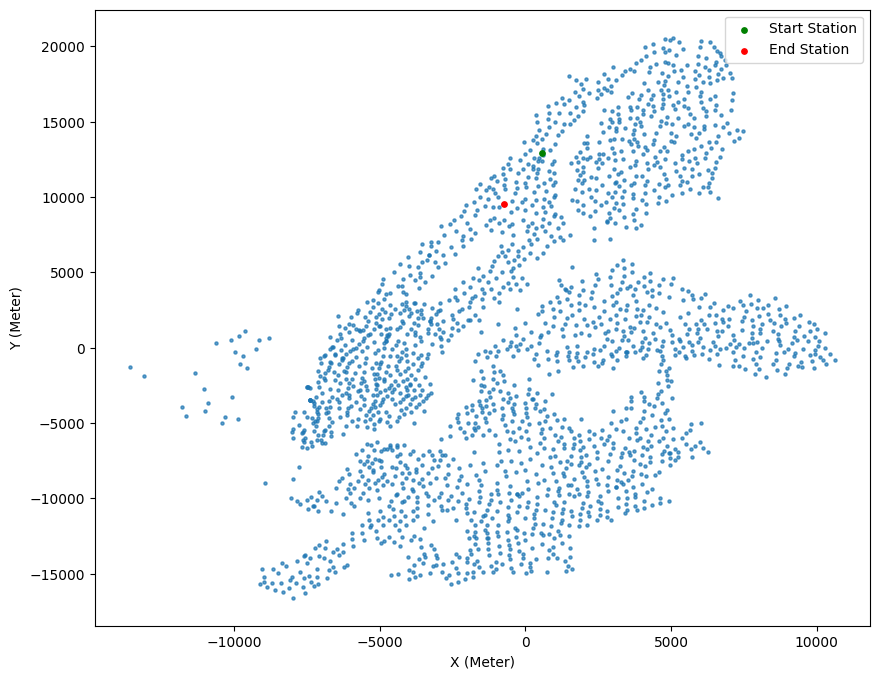

In [11]:
mark_start_end(citibike_dataset.df_rides.iloc[0], citibike_dataset.stations)

Durch Betrachtung mehrerer Samples lässt sich ggf. ein Gefühl für die gefahrenen Strecken gewinnen. Es wäre auch interessant, zu einer Startstation alle Endstationen zu markieren. Aus Zeitgründen wurde dies nicht weiter verfolgt.

Plot, in dem der Traffic aller Stationen visualisiert wird. Zur besseren Unterscheidbarkeit wird eine logarithmische Farbskala verwendet:

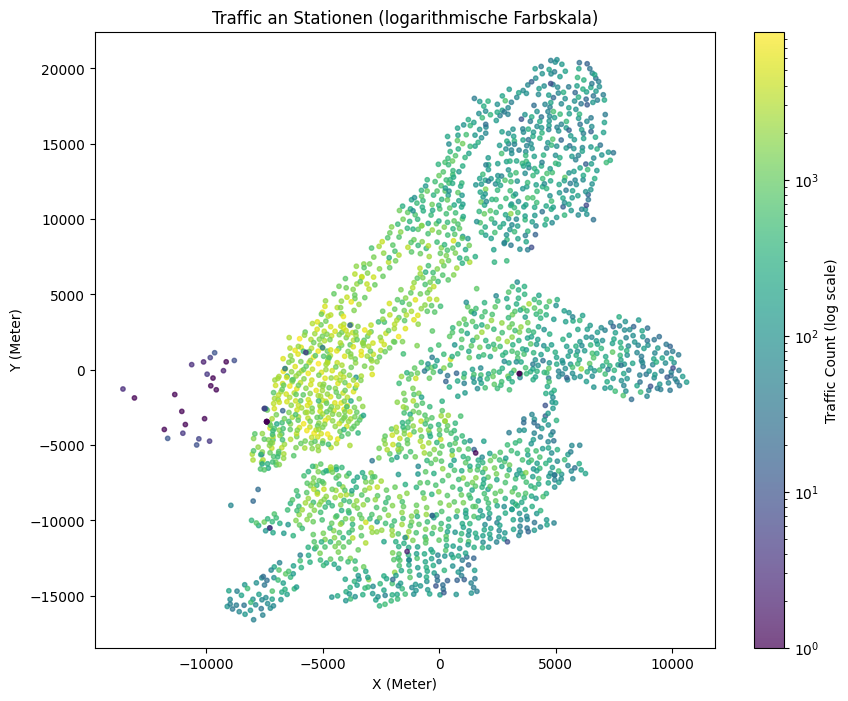

In [14]:
import matplotlib.colors as colors

station_traffic = (citibike_dataset.stations['start_count'] + citibike_dataset.stations['end_count']).values

fig, ax = plt.subplots(figsize=(10, 8))

scatter = ax.scatter(citibike_dataset.stations['x_centered'], citibike_dataset.stations['y_centered'], s=10, c=station_traffic, cmap='viridis', alpha=0.7,
                     norm=colors.LogNorm())

ax.set_xlabel("X (Meter)")
ax.set_ylabel("Y (Meter)")
ax.set_title("Traffic an Stationen (logarithmische Farbskala)")

# Farbleiste hinzufügen
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Traffic Count (log scale)')

plt.show()

Es wird die Erwartung bestätigt, dass gerade die Stationen im inneren Stadtgebiet sehr häufig verwendet werden und die Nutzung nach außen hin abnimmt. Rückschlüsse, die für Citibike hilfreich sein könnten:

- Es gibt einige Stationen, die im Vergleich zu den umliegenden Stationen weniger verwendet werden. Bei diesen Stationen könnten weitere Untersuchungen durchgeführt werden, um die Gründe dafür herauszufinden.
- Für Bereiche, in denen die Nutzung gering ist, könnten Maßnahmen zur Erhöhung der Nutzung durchgeführt werden.
- Es könnte geplant werden, an welchen Stellen zusätzliche Stationen hilfreich wären.

Untersuchung, wie oft die Stationen als Start- und Endpunkte genutzt wurden: 

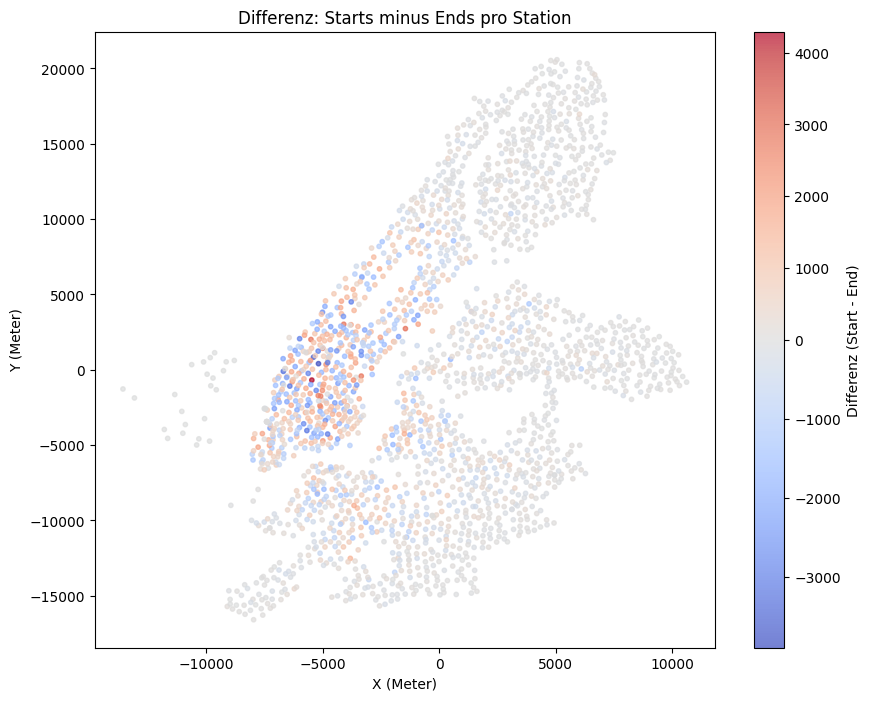

In [17]:
traffic_diff = (citibike_dataset.stations['start_count'] - citibike_dataset.stations['end_count']).values

fig, ax = plt.subplots(figsize=(10, 8))

norm = colors.TwoSlopeNorm(vmin=traffic_diff.min(),
                           vcenter=0,
                           vmax=traffic_diff.max())

scatter = ax.scatter(citibike_dataset.stations['x_centered'], citibike_dataset.stations['y_centered'], 
                     c=traffic_diff, cmap='coolwarm', norm=norm,
                     alpha=0.7, s=10)

ax.set_xlabel("X (Meter)")
ax.set_ylabel("Y (Meter)")
ax.set_title("Differenz: Starts minus Ends pro Station")

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label("Differenz (Start - End)")

plt.show()

In dem Plot werden in Rot markierte Stationen häufiger zum Start verwendet. In Blau markierte Stationen sind häufiger das Ende einer Fahrt und bei grau markierten Stationen ist das Verhältnis ausgeglichen. Hier zeigen sich allgemeine Probleme von Verleihservices mit der Verteilung der Fahrräder. Rückschlüsse, die für Citibike hilfreich sein könnten: 

- Optimierte Planung zur Umverteilung der Fahrräder. 
- Weitere Untersuchungen warum sich die teilweisen starken Unterschiede ergeben können durchgeführt werden. Die Erkenntnisse können ebenfalls für die Planung neuer Stationen verwendet werden. 

Betrachtung verschiedener Verteilungen (Histogramme) der Daten:

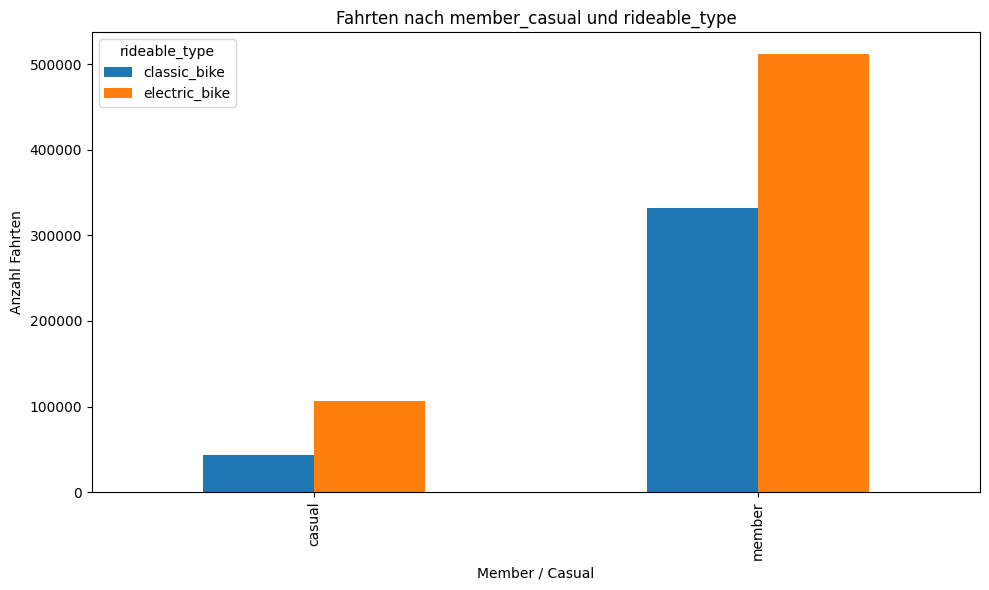

In [18]:
ride_counts = citibike_dataset.df_rides.groupby(['member_casual', 'rideable_type']).size().unstack(fill_value=0)

ride_counts.plot(kind='bar', figsize=(10,6))
plt.xlabel('Member / Casual')
plt.ylabel('Anzahl Fahrten')
plt.title('Fahrten nach member_casual und rideable_type')
plt.legend(title='rideable_type')
plt.tight_layout()
plt.show()

Ein Großteil der Fahrten wird von Membern durchgeführt. Dies ist intuitiv, da Member den Service häufiger nutzen und das Preismodell bei diesen auch eine häufige Nutzung anbietet. 

Der Anteil der klassischen Fahrräder ist bei den Membern höher als bei Casual Nutzern, was an einer besseren Fitness und höheren Preisen bei häufigerer Nutzung liegen könnte. 

Solche Erkenntnisse könnten ebenfalls bei Planungszwecken eingesetzt werden.

Untersuchung der Fahrtdauern:

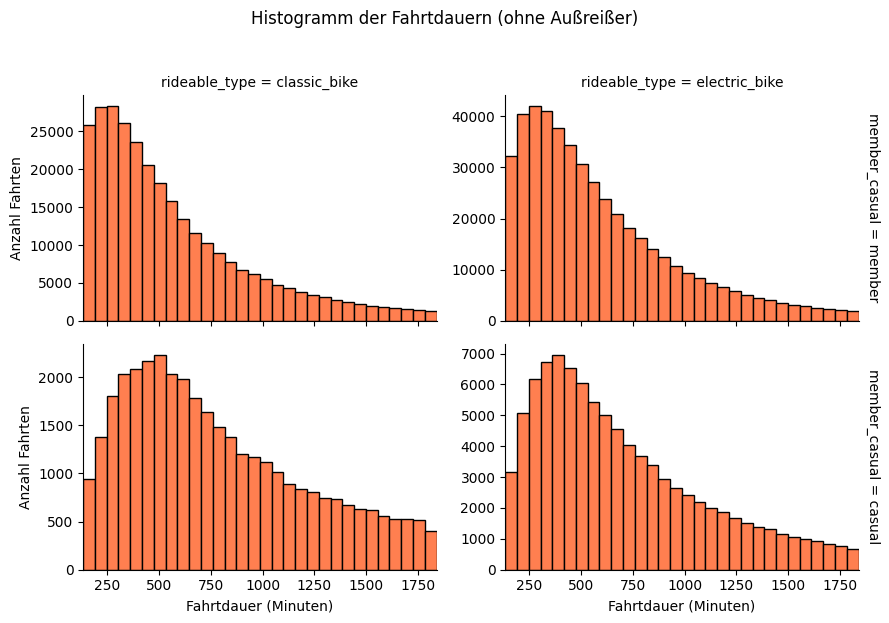

In [32]:
import seaborn as sns

# Plot without outliers
duration_low = citibike_dataset.df_rides['ride_duration'].quantile(0.05)
duration_high = citibike_dataset.df_rides['ride_duration'].quantile(0.95)
df_duration = citibike_dataset.df_rides[(citibike_dataset.df_rides['ride_duration'] >= duration_low) & (citibike_dataset.df_rides['ride_duration'] <= duration_high)]

g_duration = sns.FacetGrid(df_duration, col="rideable_type", row="member_casual", sharey=False, margin_titles=True, height=3, aspect=1.5)
g_duration.map(plt.hist, "ride_duration", bins=30, color='coral', edgecolor='black')
g_duration.set_axis_labels("Fahrtdauer (Minuten)", "Anzahl Fahrten")
g_duration.set(xlim=(duration_low, duration_high))
g_duration.fig.suptitle("Histogramm der Fahrtdauern (ohne Außreißer)", y=1.03)
plt.tight_layout()
plt.show()

Mit klassischen Fahrrädern fahren Casual Nutzer eher länger als Member. Dies könnte an Trainingseffekten liegen oder daran liegen, dass unter den Casual Nutzern auch Touristen sind, die etwas von der Stadt sehen möchten. Bei E-Bikes sieht der Unterschied etwas kleiner aus, was daran liegen könnte, dass bei diesen Rädern der Trainingseffekt eine kleinere Rolle spielt. 

**Solche Informationen könnten genutzt werden, wenn für alle Fahrer bzw. Fahrten ein konstanter bzw. einheitlicher Versicherungspreis kalkuliert werden soll.** Je länger eine Fahrt ist, desto eher kann auch ein Unfall passieren.

**Um hier (und auch in den folgenden Untersuchungen) genauere bzw. quantitative Aussagen über den Vergleich treffen zu können, müssten gezielte statistische Untersuchungen durchgeführt werden.** 

Untersuchung der zurückgelegten Luftlinie:

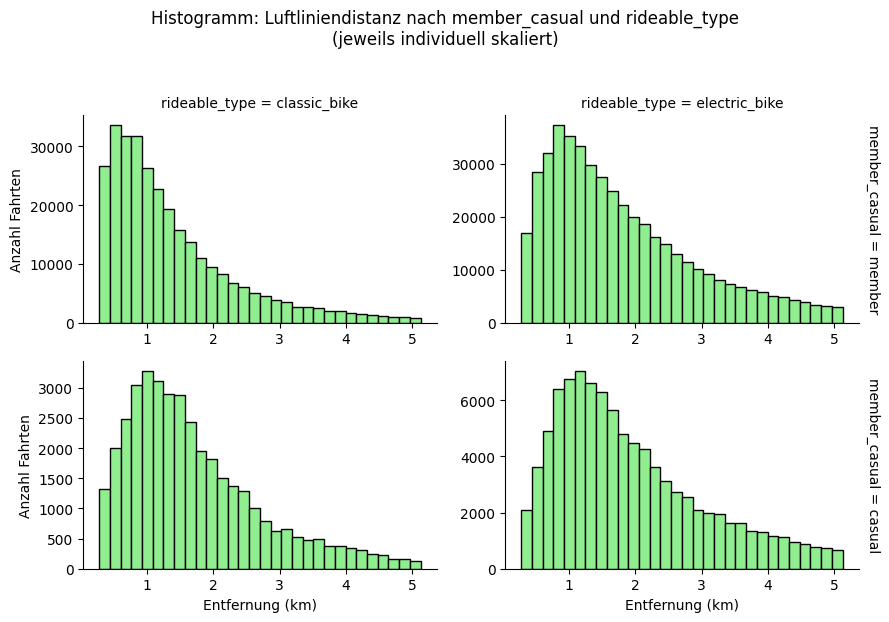

In [26]:
import numpy as np

def haversine_distance(lat1, lng1, lat2, lng2):
    R = 6371  # Erdradius in km
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lng2 - lng1)
    a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

citibike_dataset.df_rides['distance'] = haversine_distance(citibike_dataset.df_rides['start_lat'], citibike_dataset.df_rides['start_lng'], citibike_dataset.df_rides['end_lat'], citibike_dataset.df_rides['end_lng'])

# Plot without outliers
distance_low = citibike_dataset.df_rides['distance'].quantile(0.05)
distance_high = citibike_dataset.df_rides['distance'].quantile(0.95)
df_distance = citibike_dataset.df_rides[(citibike_dataset.df_rides['distance'] >= distance_low) & (citibike_dataset.df_rides['distance'] <= distance_high)]


g = sns.FacetGrid(df_distance, row="member_casual", col="rideable_type",
                  sharex=False, sharey=False, margin_titles=True, height=3, aspect=1.5)
g.map(plt.hist, "distance", bins=30, color='lightgreen', edgecolor='black')
g.set_axis_labels("Entfernung (km)", "Anzahl Fahrten")
g.fig.suptitle("Histogramm: Luftliniendistanz nach member_casual und rideable_type\n(jeweils individuell skaliert)", y=1.03)
plt.tight_layout()
plt.show()

Es zeigt sich z. B., dass E-Bike-Nutzer tendenziell weitere Entfernungen zurücklegen. Der Grund könnte auch sein, dass Personen, die eine weitere Strecke zurücklegen müssen, eher E-Bikes verwenden. 

**Auch diese Unterschiede könnten in der Versicherungskalkulation berücksichtigt werden, müssten dafür jedoch statistisch genauer quantifiziert werden.** Je mehr Entfernung zurückgelegt wird, desto größer ist die Unfallgefahr.

Untersuchung der Geschwindigkeit (da die Entfernung nur die Luftlinie ist (die nicht unbedingt der tatsächlichen Entfernung entspricht) wird die Geschwindigkeit nicht in km/h angegeben, sondern in benötigten Minuten pro km Luftlinienentfernung):

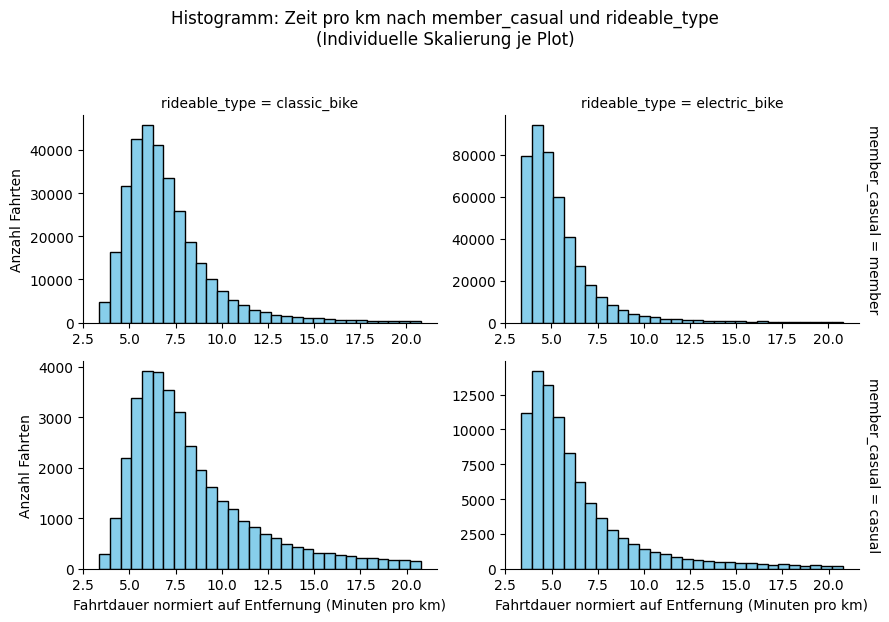

In [39]:

citibike_dataset.df_rides['time_per_km'] = citibike_dataset.df_rides['ride_duration'] / 60 / citibike_dataset.df_rides['distance']

# Plot without outliers
tp_low = citibike_dataset.df_rides['time_per_km'].quantile(0.05)
tp_high = citibike_dataset.df_rides['time_per_km'].quantile(0.95)
df_tp = citibike_dataset.df_rides[(citibike_dataset.df_rides['time_per_km'] >= tp_low) & (citibike_dataset.df_rides['time_per_km'] <= tp_high)]

g = sns.FacetGrid(df_tp, row="member_casual", col="rideable_type",
                  sharex=False, sharey=False, margin_titles=True, height=3, aspect=1.5)
g.map(plt.hist, "time_per_km", bins=30, color='skyblue', edgecolor='black')
g.set_axis_labels("Fahrtdauer normiert auf Entfernung (Minuten pro km)", "Anzahl Fahrten")
g.fig.suptitle("Histogramm: Zeit pro km nach member_casual und rideable_type\n(Individuelle Skalierung je Plot)", y=1.03)
plt.tight_layout()
plt.show()

Mit E-Bikes fahren die Kunden erwartungsgemäß schneller als mit klassischen Fahrrädern. Ebenfalls scheint es, als würden Member etwas schneller fahren als Casual Nutzer. Dies könnte daran liegen, dass sie die Strecken besser kennen oder dass sie mehr Zeitdruck haben. Zusätzlich könnten die Zeiten dadurch verzerrt werden, dass Casual Nutzer ggf. weniger häufig die schnellste Route verwenden (z. B. Touristen).  

**Auch diese Unterschiede könnten in der Versicherungskalkulation berücksichtigt werden, müssten dafür jedoch statistisch genauer quantifiziert werden.** Je schneller verschiedene Nutzer fahren, desto größer ist die Unfallgefahr.